In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import plotly.express as px

from utils_IO import get_data_in_chunks

In [2]:
# Example usage
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 1, 1)
chunk_size_days = 7  # 1 week
thing = "NavigationThing_HMD8310"
navthing  = get_data_in_chunks(thing, start_date, end_date, chunk_size_days)

/home/danielkim/Desktop/mna_lab/battery_AD/utils_IO.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(df_chunks, ignore_index=True)


In [3]:
navthing.columns

Index(['time', 'ACCELER_X', 'ACCELER_Y', 'ACCELER_Z', 'AfterDraft',
       'BeaufortNumber', 'COG', 'CurrentLat', 'CurrentLon', 'DistanceNmile',
       'DistanceToNextLeg', 'Drift', 'ForwardDraft', 'Heading', 'LegIndex',
       'WindDirection', 'WindSpeed', 'isFilteredLogSpeed', 'valuestreamname',
       'LogSpeed', 'MidPDraft', 'MidSDraft', 'SOG', 'WaterDepth', 'List',
       'RudderAngle', 'Trim_Tilt1', 'GPS_LATITUDE_DEGREE',
       'GPS_LATITUDE_HEMISPHERE', 'GPS_LATITUDE_MINUTE',
       'GPS_LONGITUDE_DEGREE', 'GPS_LONGITUDE_HEMISPHERE',
       'GPS_LONGITUDE_MINUTE', 'UTC_DAY', 'UTC_HOUR', 'UTC_MINUTE',
       'UTC_MONTH', 'UTC_SECOND', 'UTC_YEAR'],
      dtype='object')

In [ ]:
fig = px.line(x=navthing.index, y=navthing["CurrentLat"])
fig.show()

<Axes: >

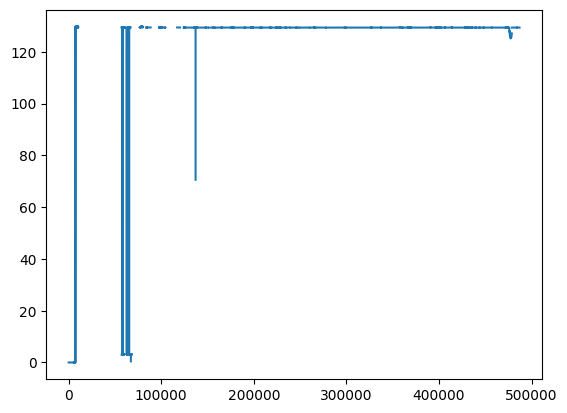

In [6]:
fig = px.line(x=navthing.index, y=navthing["CurrentLon"])
fig.show()

In [ ]:
# We consider that up to 

# Playing with lat lon columns

In [4]:
non_nan = navthing["CurrentLat"].dropna()

In [ ]:
navthing["CurrentLat"][396340:396720].plot()
plt.figure()
navthing["CurrentLon"][396340:396720].plot()

In [ ]:
ini_idx = 396340
end_idx = 396720
min_lat_idx = navthing["CurrentLat"][396340:396720].min()
max_lat_idx = navthing["CurrentLat"][396340:396720].max()
max_lon_idx = navthing["CurrentLon"][396340:396720].max()
min_lon_idx = navthing["CurrentLon"][396340:396720].min()
ini_lat = navthing["CurrentLat"][ini_idx]
ini_lon = navthing["CurrentLon"][ini_idx]
min_min_lat_idx = navthing["CurrentLat"][min_lat_idx]
min_min_lon_idx = navthing["CurrentLat"][min_lat_idx]

min_max_lat_idx = navthing["CurrentLat"][min_lat_idx]
min_max_lon_idx = navthing["CurrentLat"][min_lat_idx]

In [19]:
# Trip 1: 155300:155550
# Trip 2: 396340:396720

<Axes: >

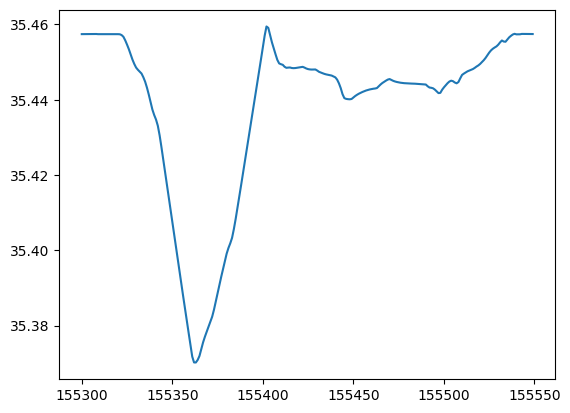

In [4]:
navthing["CurrentLat"][155300:155550].plot()

<Axes: >

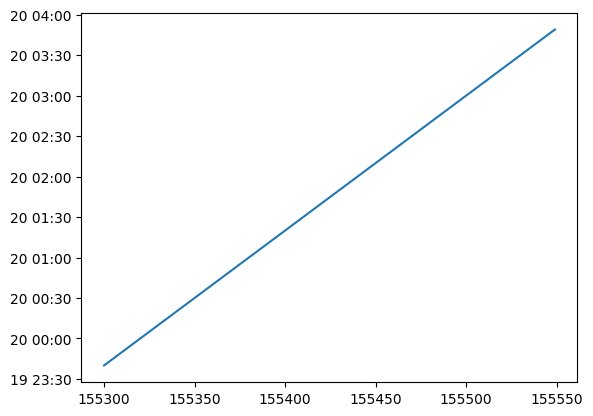

In [56]:
pd.to_datetime(navthing["time"][155300:155550]).plot()

<Axes: >

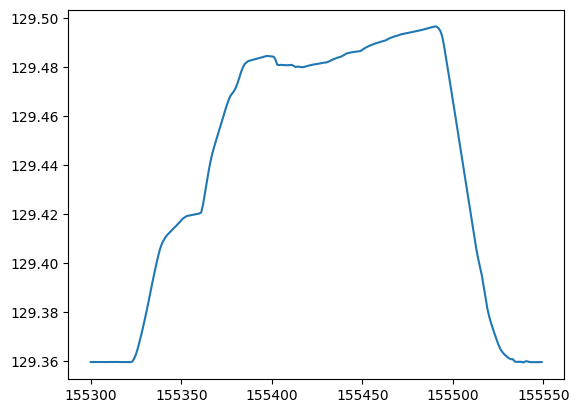

In [59]:
navthing["CurrentLon"][155300:155550].plot()

<Axes: >

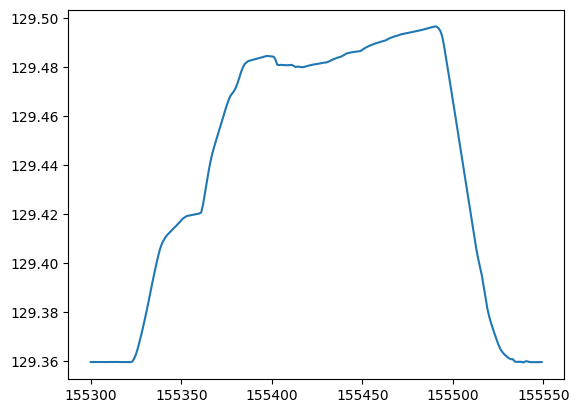

In [67]:
navthing["CurrentLon"][155300:155550].plot()

In [69]:
navthing["CurrentLat"][155300]

35.45744

In [73]:
navthing["CurrentLon"][155300:155550].idxmax()

155490

In [74]:
maxlong_idx = navthing["CurrentLon"][155300:155550].idxmax()
minlat_idx = navthing["CurrentLat"][155300:155550].idxmin()

print(navthing.loc[maxlong_idx, "CurrentLat"], navthing.loc[maxlong_idx, "CurrentLon"])
print(navthing.loc[minlat_idx, "CurrentLat"], navthing.loc[minlat_idx, "CurrentLon"])

35.444044999999996 129.496615
35.370176666666666 129.42810333333333


In [71]:
navthing["CurrentLon"][155300:155550].max(), navthing["CurrentLat"][155300:155550].max()

35.459473333333335

# Haversine library

In [7]:
navthing['timestamp'] = pd.to_datetime(navthing['time'])  # Ensure your data has a proper datetime format

# Calculate distances
# Shift latitude and longitude data to align for distance calculation between consecutive points
navthing['shifted_lon'] = navthing['CurrentLon'].shift(-1)
navthing['shifted_lat'] = navthing['CurrentLat'].shift(-1)

In [10]:
# Apply the haversine function
navthing['distance'] = navthing.apply(lambda row: haversine((row['CurrentLat'], row['CurrentLon']), 
                                                (row['shifted_lat'], row['shifted_lon']), 
                                                unit=Unit.KILOMETERS), axis=1)

<Axes: >

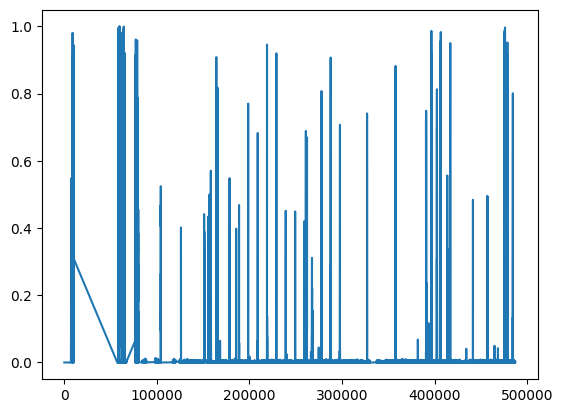

In [33]:
navthing.loc[navthing["distance"]<1, "distance"].plot()

In [44]:
# Define a threshold for significant movement
min_significant_distance = 0.1  # Change this threshold based on what you consider significant
max_significant_distance = 1

# Identify significant movements
navthing['significant_move'] = (navthing['distance'] > min_significant_distance) & (navthing['distance'] < max_significant_distance)

# Segmenting the data where significant movement starts
navthing['segment_start'] = navthing['significant_move'] & (~navthing['significant_move']).shift(1)
navthing['segment_end'] = navthing['significant_move'] & (~navthing['significant_move']).shift(-1)

# Optionally, to get more meaningful insights, extract periods of movement
segments = navthing[(navthing['segment_start']) | (navthing['segment_end'])].copy()

In [45]:
# If you want more detailed analysis like segment duration, distance, etc.
if not segments.empty:
    segments['duration'] = segments['timestamp'].diff().fillna(pd.Timedelta(seconds=0))
    segments['cumulative_distance'] = segments['distance'].cumsum()

# Clean up DataFrame to include relevant columns
segments = segments[['timestamp', 'CurrentLat', 'CurrentLon', 'distance', 'segment_start', 'segment_end', 'duration', 'cumulative_distance']]

# Print or save the segments
print(segments)


                       timestamp  CurrentLat  CurrentLon  distance  \
7346   2022-08-29 00:45:00+00:00   35.505568  129.392078  0.109695   
7431   2022-08-29 02:10:00+00:00   35.431728  129.527295  0.109332   
7435   2022-08-29 02:14:00+00:00   35.434560  129.527253  0.232601   
7438   2022-08-29 02:17:00+00:00   35.440212  129.528323  0.131313   
7445   2022-08-29 02:24:00+00:00   35.444220  129.529532  0.102133   
...                          ...         ...         ...       ...   
478667 2023-08-10 09:39:00+00:00   33.649888  127.103462  0.460995   
484433 2023-08-23 06:21:00+00:00   35.448175  129.470565  0.409830   
484450 2023-08-23 06:38:00+00:00   35.463757  129.479673  0.450556   
484452 2023-08-23 06:43:00+00:00   35.443390  129.480110  0.454325   
484494 2023-08-23 07:27:00+00:00   35.455197  129.362397  0.117545   

        segment_start  segment_end         duration  cumulative_distance  
7346             True        False  0 days 00:00:00             0.109695  
7431     

# Plot the coordinates

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

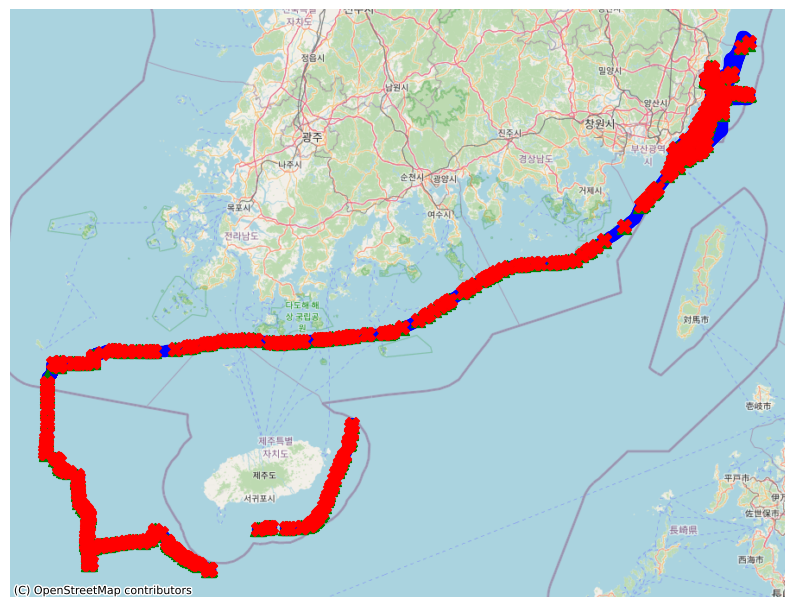

In [58]:
# Create a GeoDataFrame with unfiltered distances
df = navthing[300000:].copy()
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.CurrentLon, df.CurrentLat),
    crs="EPSG:4326"  # WGS 84 latitude-longitude projection
)

# Convert to Web Mercator projection for use with contextily
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', marker='o', markersize=50)  # Plot all points in blue

# Highlight starts and ends
starts = gdf[gdf['segment_start']]
ends = gdf[gdf['segment_end']]
starts.plot(ax=ax, color='green', marker='^', markersize=100)  # Start points in green
ends.plot(ax=ax, color='red', marker='X', markersize=100)  # End points in red

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Adding a base map
ax.set_axis_off()
plt.show()

In [72]:
high_distance_idx = df.loc[df["distance"]>10, "distance"].index
navthing.loc[high_distance_idx[0]-3:high_distance_idx[0]+3, ["CurrentLat", "CurrentLon"]]

,CurrentLat,CurrentLon
478387,32.876930,126.202757
478388,32.878340,126.203130
478389,32.878340,126.203130
478390,32.880642,126.203820
478391,33.093513,126.500003
478392,33.093837,126.503050
478393,33.094203,126.506078


<Axes: >

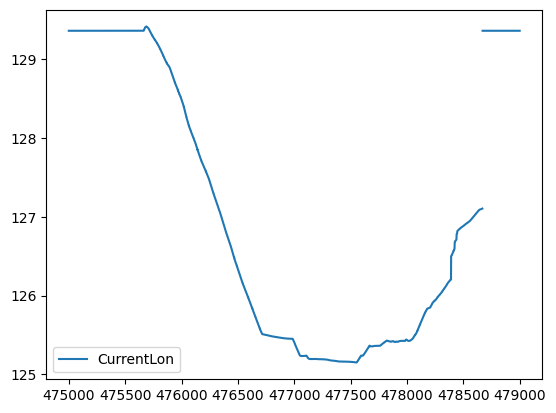

<Figure size 640x480 with 0 Axes>

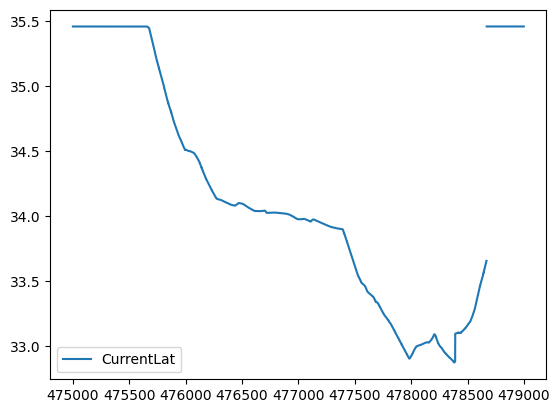

In [88]:
navthing[["CurrentLon"]][475000:479000].plot()
plt.figure()
navthing[["CurrentLat"]][475000:479000].plot()

In [83]:
print(navthing[["CurrentLon"]][475000:].min(), navthing[["CurrentLon"]][475000:].max())

CurrentLon    125.152327
dtype: float64 CurrentLon    129.480617
dtype: float64


In [82]:
print(navthing[["CurrentLat"]][470000:].min(), navthing[["CurrentLat"]][470000:].max())

CurrentLat    32.87189
dtype: float64 CurrentLat    35.483065
dtype: float64


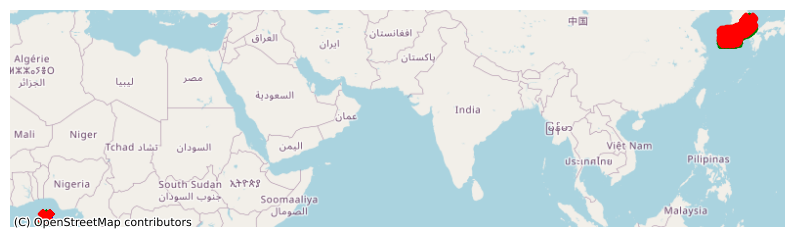

In [56]:
# Create a GeoDataFrame with filtered distances
gdf = gpd.GeoDataFrame(
    segments, geometry=gpd.points_from_xy(segments.CurrentLon, segments.CurrentLat),
    crs="EPSG:4326"  # WGS 84 latitude-longitude projection
)

# Convert to Web Mercator projection for use with contextily
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', marker='o', markersize=50)  # Plot all points in blue

# Highlight starts and ends
starts = gdf[gdf['segment_start']]
ends = gdf[gdf['segment_end']]
starts.plot(ax=ax, color='green', marker='^', markersize=100)  # Start points in green
ends.plot(ax=ax, color='red', marker='X', markersize=100)  # End points in red

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Adding a base map
ax.set_axis_off()
plt.show()

In [55]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'BlackAndWhite': {'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'name': 'OpenStreetMap.BlackAndWhite'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'es/map/v1',
   'apikey': '<insert 